In [18]:
import numpy as np
import tensorflow as tf
from object_detection.utils import dataset_util
import os
from tqdm import tqdm
import keras as ke

flags = tf.app.flags
train_output_path = '/home/dlrc/tf_train_dir/data/train.record'
eval_output_path = '/home/dlrc/tf_train_dir/data/eval.record'
FLAGS = flags.FLAGS
IMAGES_DIR = '/home/dlrc/datasets/object_detection_dataset_v1/images'
BBOXES_DIR ='/home/dlrc/datasets/object_detection_dataset_v1/bboxes'

%matplotlib inline

def create_block_tf_proto(encoded_block_image_data, filename, image_format, image_dim=(640,480), bboxes=None):
    """Creates a tf.Example proto from sample camera image.

    Args:
    encoded_block_image_data: The jpg encoded data of the block image.

    Returns:
    tf_example: The created tf.Example.
    """
    
    height, width = image_dim

    classes_text = ['lego_block'.encode()]*bboxes.shape[0]
    classes = [1]*bboxes.shape[0]
    
    bboxes = bboxes.T
    print(bboxes)
    xmins, xmaxs, ymins, ymaxs = bboxes[0], bboxes[2], bboxes[1], bboxes[3]
    xmins = xmins / image_dim[0]
    xmaxs = xmaxs / image_dim[0]
    ymins = ymins / image_dim[1]
    ymaxs = ymaxs / image_dim[1]
    
    assert not np.any(xmaxs < xmins)
    assert not np.any(ymaxs < ymins)
    assert not np.any(xmaxs >= 1)
    assert not np.any(ymaxs >= 1)
  
    
    bboxes = np.asarray([xmins, xmaxs, ymins, ymaxs])
    if np.any(bboxes >= 1):
        raise Exception("Not normalized " + str(bboxes))
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename.encode()),
      'image/source_id': dataset_util.bytes_feature(filename.encode()),
      'image/encoded': dataset_util.bytes_feature(encoded_block_image_data),
      'image/format': dataset_util.bytes_feature(image_format.encode()),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example


def generate_records(output_path, files):
    

    writer = tf.python_io.TFRecordWriter(output_path)
    print(files.shape)
    for image_path, bbox_path in tqdm(files):
        image_path = os.path.join(IMAGES_DIR, image_path)
        bbox_path = os.path.join(BBOXES_DIR, bbox_path)
        img_file = open(image_path, 'rb')
        img_encoded = img_file.read()
        bboxes = np.load(bbox_path)
        tf_example = create_block_tf_proto(filename=image_path, bboxes=bboxes, encoded_block_image_data=img_encoded,
                                image_format=u'jpeg')
        writer.write(tf_example.SerializeToString())

def generate_train_eval():
    
    image_files = sorted(os.listdir(IMAGES_DIR))
    bbox_files = sorted(os.listdir(BBOXES_DIR))
    
    train_indices = slice(0,int(0.9*len(image_files)))
    eval_indices = slice(int(0.9*len(image_files)), -1)
    zipped_files = np.vstack((image_files, bbox_files)).T
    train_files = zipped_files[train_indices]
    eval_files = zipped_files[eval_indices]
    
    generate_records(train_output_path, train_files)
    generate_records(eval_output_path, eval_files)
    


Using TensorFlow backend.


In [15]:
!sh ~/.bashrc
!export PYTHONPATH=$PYTHONPATH:/home/dlrc/projects/tensorflow/models/object_detection

In [1]:
import tensorflow as tf

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = "/home/dlrc/nn_object_detection/tf_train_dir/models/faster_rcnn_resnet_lego_v1/train/frozen_inference_graph.pb"
PATH_TO_LABELS = "/home/dlrc/nn_object_detection/tf_train_dir/data/label_map.pbtxt"
NUM_CLASSES = 2

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [16]:
from utils import label_map_util
NUM_CLASSES = 2

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [5]:
import os
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/dlrc/datasets/object_detection_dataset_v1/images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, f) for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [36]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import sys
import tensorflow as tf
sys.path.append("/home/dlrc/projects/tensorflow/models/object_detection")
from utils import label_map_util
import numpy as np

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = "/home/dlrc/nn_object_detection/tf_train_dir/models/faster_rcnn_resnet_lego_v1/train/frozen_inference_graph.pb"
PATH_TO_LABELS = "/home/dlrc/nn_object_detection/tf_train_dir/data/label_map.pbtxt"
NUM_CLASSES = 2

class NNObjectDetector(object):
  
  def __init__(self, frozen_graph_path, path_to_labels):
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(frozen_graph_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    self.detection_graph = detection_graph
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    self.categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)
    self.sess =  tf.Session(graph=self.detection_graph)
    
  def detect(self,image):
    
    sess = self.sess
    # Definite input and output Tensors for detection_graph
    image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    return boxes, scores, classes, num

  
  

  
detector = NNObjectDetector(PATH_TO_CKPT, PATH_TO_LABELS)


Time:  1.042872428894043
Time:  0.14337682723999023


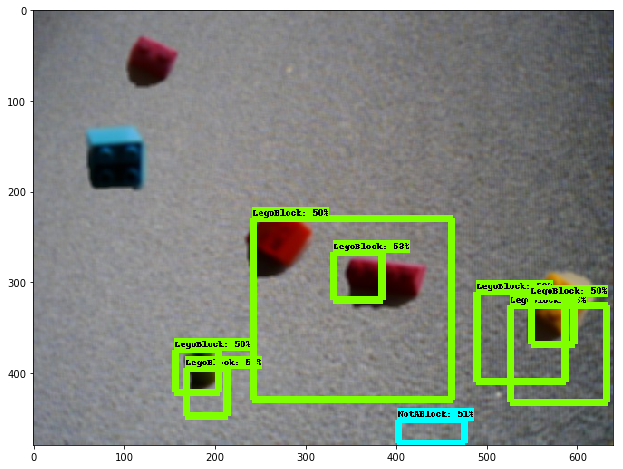

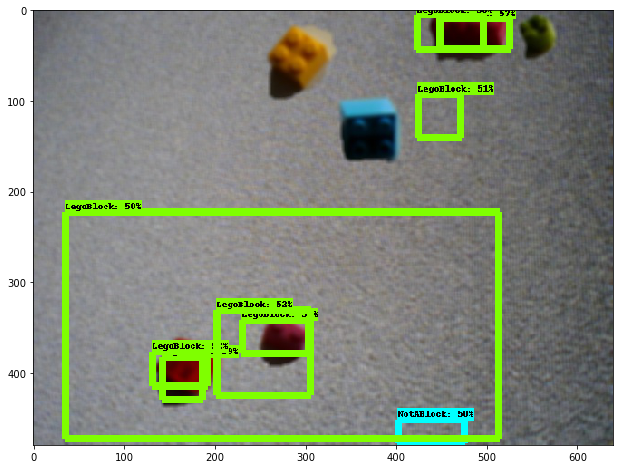

In [37]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("/home/dlrc/projects/tensorflow/models/object_detection")
from utils import visualization_utils as vis_util
import time

for image_path in TEST_IMAGE_PATHS[0:2]:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  tp = time.time()
  (boxes, scores, classes, num) = detector.detect(image_np_expanded)
  print("Time: ", time.time()-tp)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.squeeze(boxes),
      np.squeeze(classes).astype(np.int32),
      np.squeeze(scores),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)



    
    

In [21]:
print(scores)

[[ 0.6303013   0.55527371  0.55403847  0.54084557  0.52486581  0.52318054
   0.51140547  0.50778019  0.50712281  0.50364393  0.50182068  0.50025743
   0.49675441  0.49652535  0.49141952  0.49119049  0.48801655  0.48449284
   0.48393017  0.4818942   0.47808     0.46545807  0.46503705  0.46471676
   0.46250579  0.46028492  0.45987341  0.45924079  0.45567462  0.45382789
   0.45292261  0.45250407  0.45233232  0.45187142  0.45121178  0.45074597
   0.44771534  0.44697854  0.44612637  0.44485644  0.44390449  0.4422586
   0.44074097  0.43988866  0.43970889  0.43902403  0.4388842   0.43823722
   0.4365387   0.43519855  0.43514565  0.43408266  0.43368718  0.4309541
   0.42987865  0.42958936  0.4287546   0.42857727  0.42695844  0.42508385
   0.4246968   0.4245947   0.42450377  0.4225345   0.42208809  0.42146254
   0.42060107  0.41948065  0.41903421  0.4189046   0.41847536  0.41798306
   0.41673362  0.41659647  0.41599202  0.41593331  0.41564775  0.41470659
   0.41283295  0.41137469  0.41113815  0